## Load data

In [1]:
import pandas as pd
import ast
import numpy as np

# Load in data
admissions = 'tedsa_puf_2019.csv'
df_raw = pd.read_csv(f'../../Downloads/{admissions}')

## Filter out select rows and columns

In [2]:
# Get count of original number of rows
old_rows = len(df_raw)

# Drop defined columns (year of admission, case id, geographic metro area, geographic division, geographic region)
columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010', 'DIVISION', 'REGION']
df = df_raw.drop(columns=columns_to_drop)
print(f'Dropped {len(columns_to_drop)} columns ({len(df.columns)} remain)')

# Drop values where dependent variable is unknown
df = df[df['METHUSE'] != -9]

# Only keep patients admitted with self-described use of an opioid as their primary substance use (i.e., SUB1 = 5, 6, or 7)
df = df[df['SUB1'].between(5, 7)]
new_rows = len(df)
percent_change = round(100*(old_rows-new_rows)/old_rows, 1)
print(f'Dropped {"{:,}".format(old_rows-new_rows)} observations or {percent_change}% of the data ({"{:,}".format(new_rows)} rows remain)')

df = df.reset_index(drop='index')

Dropped 5 columns (57 remain)
Dropped 1,340,233 observations or 71.9% of the data (524,134 rows remain)


## Balance dataset

In [3]:
# Split into two dataframes, printing result
df_ones = df[df['METHUSE']==1]
df_twos = df[df['METHUSE']==2]
print('Classes before down-sampling:', len(df_ones), len(df_twos))

# Sample down df_twos to the length of df_ones, printing result
ratio = len(df_ones)/len(df_twos)
df_twos = df_twos.sample(frac=ratio)
print('Classes after down-sampling:', len(df_ones), len(df_twos))

# Recombine and shuffle for good measure
df = pd.concat([df_ones, df_twos], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

Classes before down-sampling: 211743 312391
Classes after down-sampling: 211743 211743


## Make dataset human-readable

In [4]:
# Load in variable dictionary
with open('VariableDictionary.txt') as file:
    variable_dict_string = file.read()
    variable_dict = ast.literal_eval(variable_dict_string)

# Rename entries in column according to dictionary
df2 = df.copy()
for col, col_dict in variable_dict.items():
    if col in df2.columns:
        for old_value, new_value in variable_dict[col].items():
            df2[col] = df2[col].replace(old_value, new_value)

# Rename "-9" values as "Unknown"
for col in df2.columns:
    df2[col] = df2[col].replace(-9, 'Unknown')

# Merge DETNLF (detailed not in labor force) into EMPLOY==4 (not in labor force)
detailed_employ = []

for idx, value in df2.iterrows():
    if value['EMPLOY'] == 'NotInLaborForce':
        if value['DETNLF'] == 'Unknown':
            # Assign 'UnknownNotInLaborForce' if 'NotInLaborForce' and 'Unknown'
            detailed_employ.append('UnknownNotInLaborForce')
        else:
            # Otherwise, assign as the DETNLF value
            detailed_employ.append(value['DETNLF'])
    else:
        # Assign the EMPLOY value if not 'NotInLaborForce'
        detailed_employ.append(value['EMPLOY'])

# Add a new column for detailed employment and drop the two source columns
df2['DETEMPLOY'] = detailed_employ
df2 = df2.drop(columns=['EMPLOY', 'DETNLF'])

# Convert dependent variable to binary integer
df2['METHUSE'] = df2['METHUSE'].replace('MethUse', 1)
df2['METHUSE'] = df2['METHUSE'].replace('NoMethUse', 0)

# XGBoost and Shapley

### Make machine-readable dataset (encoding)

In [5]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df4 = df2.copy()
# df4 = df4.sample(frac=0.1)  # small size for testing code

df4['STFIPS'] = df4['STFIPS'].astype('category').cat.codes
df4['EDUC'] = OrdinalEncoder(categories=[['Unknown', 'Grade8OrLess', 'Grade9To11', 'Grade12OrGED', '1To3yCollege', '4yCollegePlus']]).fit_transform(df4[['EDUC']])
df4['MARSTAT'] = df4['MARSTAT'].astype('category').cat.codes
df4['SERVICES'] = df4['SERVICES'].astype('category').cat.codes
df4['DETCRIM'] = df4['DETCRIM'].astype('category').cat.codes
df4['NOPRIOR'] = OrdinalEncoder(categories=[['Unknown', '0PriorTreatments', '1PriorTreatments', '2PriorTreatments', '3PriorTreatments',
                                            '4PriorTreatments', '5PlusPriorTreatments']]).fit_transform(df4[['NOPRIOR']])
df4['PSOURCE'] = df4['PSOURCE'].astype('category').cat.codes
df4['ARRESTS'] = OrdinalEncoder(categories=[['Unknown', '0Arrest', '1Arrest', '2PlusArrest']]).fit_transform(df4[['ARRESTS']])
# df4['METHUSE'] = df4['METHUSE'].astype('category').cat.codes
df4['PSYPROB'] = df4['PSYPROB'].astype('category').cat.codes
df4['PREG'] = df4['PREG'].astype('category').cat.codes
df4['GENDER'] = df4['GENDER'].astype('category').cat.codes
df4['VET'] = df4['VET'].astype('category').cat.codes
df4['LIVARAG'] = df4['LIVARAG'].astype('category').cat.codes
df4['DAYWAIT'] = OrdinalEncoder(categories=[['Unknown', '0DaysWait', '1To7DaysWait', '8To14DaysWait', '15To30DaysWait',
                                            '31PlusDaysWait']]).fit_transform(df4[['DAYWAIT']])
df4['DSMCRIT'] = df4['DSMCRIT'].astype('category').cat.codes
df4['AGE'] = OrdinalEncoder(categories=[['Age12To14', 'Age15To17', 'Age18To20', 'Age21To24', 'Age25To29', 'Age30To34', 'Age35To39', 'Age40To44',
                                        'Age45To49', 'Age50To54', 'Age55To64', 'Age65Plus' ]]).fit_transform(df4[['AGE']])
df4['RACE'] = df4['RACE'].astype('category').cat.codes
df4['ETHNIC'] = df4['ETHNIC'].astype('category').cat.codes
df4['PRIMINC'] = df4['PRIMINC'].astype('category').cat.codes
df4['SUB1'] = df4['SUB1'].astype('category').cat.codes
df4['SUB2'] = df4['SUB2'].astype('category').cat.codes
df4['SUB3'] = df4['SUB3'].astype('category').cat.codes
df4['ROUTE1'] = df4['ROUTE1'].astype('category').cat.codes
df4['ROUTE2'] = df4['ROUTE2'].astype('category').cat.codes
df4['ROUTE3'] = df4['ROUTE3'].astype('category').cat.codes
df4['FREQ1'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ1']])
df4['FREQ2'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ2']])
df4['FREQ3'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ3']])
df4['FRSTUSE1'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE1']])
df4['FRSTUSE2'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE2']])
df4['FRSTUSE3'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE3']])
df4['HLTHINS'] = df4['HLTHINS'].astype('category').cat.codes
df4['PRIMPAY'] = df4['PRIMPAY'].astype('category').cat.codes
df4['FREQ_ATND_SELF_HELP'] = OrdinalEncoder(categories=[['Unknown', 'NoAttendance', 'SomeAttendance', '1To3TimesPastMonth', '4To7TimesPastMonth',
                                                        '8To30TimesPastMonth']]).fit_transform(df4[['FREQ_ATND_SELF_HELP']])
df4['ALCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['ALCFLG']])
df4['COKEFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['COKEFLG']])
df4['MARFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MARFLG']])
df4['HERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HERFLG']])
df4['METHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['METHFLG']])
df4['OPSYNFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OPSYNFLG']])
df4['PCPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['PCPFLG']])
df4['HALLFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HALLFLG']])
df4['MTHAMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MTHAMFLG']])
df4['AMPHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['AMPHFLG']])
df4['STIMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['STIMFLG']])
df4['BENZFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BENZFLG']])
df4['TRNQFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['TRNQFLG']])
df4['BARBFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BARBFLG']])
df4['SEDHPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['SEDHPFLG']])
df4['INHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['INHFLG']])
df4['OTCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTCFLG']])
df4['OTHERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTHERFLG']])
# df4['DIVISION'] = df4['DIVISION'].astype('category').cat.codes
# df4['REGION'] = df4['REGION'].astype('category').cat.codes
df4['IDU'] = OrdinalEncoder(categories=[['NoIDU', 'IDU']]).fit_transform(df4[['IDU']])
df4['ALCDRUG'] = OrdinalEncoder(categories=[['OtherDrugs', 'AlcoholAndDrugs']]).fit_transform(df4[['ALCDRUG']])
df4['DETEMPLOY'] = df4['DETEMPLOY'].astype('category').cat.codes

## Train XG Boost model

In [7]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df4.drop('METHUSE', axis=1)
y = df4['METHUSE'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [8]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Search the parameter grid
# Docs: https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#2.-XGBoost-hyperparameters-
defined_space={'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
       'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
       'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
       'max_depth': hp.quniform("max_depth", 3, 27, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.choice('n_estimators', range(100, 1000)),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
       'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'subsample': hp.quniform('subsample', 0.5, 1, 0.05)
    }

def objective(space):
    clf = xgb.XGBClassifier(colsample_bytree=round(space['colsample_bytree'], 0),
                          early_stopping_rounds=10,
                          eta=space['eta'],
                          eval_metric='auc',
                          gamma=space['gamma'],
                          learning_rate=space['learning_rate'],
                          max_depth=int(round(space['max_depth'], 0)),
                          min_child_weight=space['min_child_weight'],
                          n_estimators=space['n_estimators'],
                          objective='binary:logistic',
                          reg_alpha=space['reg_alpha'],
                          reg_lambda=space['reg_lambda'],
                          seed=24,
                          subsample=round(space['subsample'], 0))

    # Evaluate the model and record performance metrics
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test,y_pred)

    print (f"Accuracy: {round(accuracy, 4)}, AUC: {round(auc, 4)}")
    return {'loss': -accuracy, 'status': STATUS_OK }

In [9]:
# Begin training
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = defined_space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

Accuracy: 0.6836 AUC: 0.7426                           
Accuracy: 0.8524 AUC: 0.9354                                                      
Accuracy: 0.7345 AUC: 0.8138                                                         
Accuracy: 0.7292 AUC: 0.808                                                          
Accuracy: 0.8399 AUC: 0.925                                                          
Accuracy: 0.8427 AUC: 0.9276                                                          
Accuracy: 0.7412 AUC: 0.8243                                                          
Accuracy: 0.7177 AUC: 0.7932                                                          
Accuracy: 0.8417 AUC: 0.9274                                                         
Accuracy: 0.8505 AUC: 0.9336                                                         
Accuracy: 0.7347 AUC: 0.8142                                                          
Accuracy: 0.7351 AUC: 0.8189                                                       

In [9]:
"""
# Best from 100 runs

 {'colsample_bytree': 0.61,
 'eta': 0.25,
 'gamma': 0.8,
 'learning_rate': 0.22,
 'max_depth': 16.0,
 'min_child_weight': 0.0,
 'n_estimators': 812,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9241629285526229,
 'subsample': 0.9}
"""

# best_hyperparams = {'colsample_bytree': 0.61,
#                      'eta': 0.25,
#                      'gamma': 0.8,
#                      'learning_rate': 0.22,
#                      'max_depth': 16.0,
#                      'min_child_weight': 0.0,
#                      'n_estimators': 812,
#                      'reg_alpha': 40.0,
#                      'reg_lambda': 0.9241629285526229,
#                      'subsample': 0.9}

best_hyperparams

{'colsample_bytree': 0.61,
 'eta': 0.25,
 'gamma': 0.8,
 'learning_rate': 0.22,
 'max_depth': 16.0,
 'min_child_weight': 0.0,
 'n_estimators': 812,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9241629285526229,
 'subsample': 0.9}

In [11]:
# Train best model
best_hyperparams_formatted = best_hyperparams.copy()
best_hyperparams_formatted['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams_formatted['eval_metric'] = 'auc'
best_hyperparams_formatted['objective'] = 'binary:logistic'
best_hyperparams_formatted['seed'] = 24

best_model = xgb.XGBClassifier(**best_hyperparams_formatted)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
              early_stopping_rounds=None, enable_categorical=False, eta=0.45,
              eval_metric='auc', gamma=0.7000000000000001, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.34, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=18, max_leaves=0,
              min_child_weight=4.0, missing=nan, monotone_constraints='()',
              n_estimators=45, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=24, reg_alpha=40.0, ...)

In [12]:
# Evaluate the model and record performance metrics
evaluation = [( X_train, y_train), ( X_test, y_test)]
best_pred = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, best_pred>0.5)
y_best_pred = best_model.predict_proba(X_test)[:,1]
best_auc = roc_auc_score(y_test,y_best_pred)

print (f"Accuracy: {round(best_accuracy, 4)}, AUC: {round(best_auc, 4)}")

Accuracy: 0.8482, AUC: 0.9322


### Interpretability

In [141]:
import shap
import numpy as np

# Generate Shapley values
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [142]:
shap_values   # Can we export these values as a csv? Trying to find a way to not have to run them each time

.values =
array([[-6.14417195e-01, -1.07647009e-01, -8.96000713e-02, ...,
        -1.23644751e-02,  6.48894254e-03,  6.44573122e-02],
       [-4.01042178e-02, -6.68558925e-02,  8.15624669e-02, ...,
        -7.13172629e-02,  1.12182824e-02, -2.36332673e-03],
       [-1.22391188e+00,  3.59972045e-02,  8.33280291e-03, ...,
         2.85950415e-02,  1.04355039e-02, -6.46168739e-03],
       ...,
       [ 1.51008248e-01,  1.01002909e-01, -2.31086593e-02, ...,
         5.64009584e-02,  1.05127813e-02, -6.46924302e-02],
       [ 3.76244895e-02, -7.54593057e-04,  8.16535205e-02, ...,
         1.06938146e-01,  6.30442845e-03,  3.02827787e-02],
       [ 2.36923695e-01,  1.04050718e-01,  1.64596252e-02, ...,
        -5.35444357e-02,  8.89453478e-03, -1.31306812e-01]], dtype=float32)

.base_values =
array([-0.01637657, -0.01637657, -0.01637657, ..., -0.01637657,
       -0.01637657, -0.01637657], dtype=float32)

.data =
array([[ 4.,  4.,  4., ...,  1.,  0.,  4.],
       [19.,  3.,  2., ...,  0.,  0.

In [143]:
import os
os.system('say "Work complete"')

0

In [145]:
def absolute_share(input_list):
    absolute_list = [abs(i) for i in input_list]
    absolute_share_list = [j/sum(absolute_list) for j in absolute_list]
    return absolute_share_list

# Show table of top Shapley values
feature_names = X.columns
result = pd.DataFrame(shap_values.values, columns=feature_names, index=X.index)
# result.to_csv('shapley_results.csv', index=False)

values = np.abs(result.values).mean(0)
abs_values = absolute_share(np.abs(result.values).mean(0))
shap_importance = pd.DataFrame(list(zip(feature_names, values, abs_values)), columns=['feature_name','feature_importance', 'feature_importance_out_of_100'])
shap_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_importance.reset_index(drop=True)

,feature_name,feature_importance,feature_importance_out_of_100
0,SERVICES,1.169295,0.221355
1,STFIPS,0.808112,0.152981
2,PSOURCE,0.297946,0.056403
3,NOPRIOR,0.260033,0.049226
4,HLTHINS,0.209499,0.039660
5,FREQ1,0.171629,0.032491
6,DSMCRIT,0.164464,0.031134
7,FREQ_ATND_SELF_HELP,0.139806,0.026466
8,PRIMINC,0.130791,0.024760
9,PRIMPAY,0.129681,0.024550


In [146]:
# (-0.1199*12982 + -0.0953*13336 + 0.0634*53816 + -0.0368*4564)/(12982 + 13336 + 53816 + 4564)
(0.1295*12982 + 0.0995*13336 + 0.0641*53816 + 0.0630*4564)/(12982 + 13336 + 53816 + 4564)

0.07963869985123616

In [147]:
livarag_dict = {0:'DependLiving', 1:'Homeless', 2:'IndependentLiving', 3:'Unknown'}
print(livarag_dict)
X.value_counts('LIVARAG')
# df2.value_counts('LIVARAG')

{0: 'DependLiving', 1: 'Homeless', 2: 'IndependentLiving', 3: 'Unknown'}


LIVARAG
2    268885
1     66100
0     65813
3     22688
dtype: int64

In [148]:
# result = pd.read_csv('shapley_results.csv')
result_homeless = result.copy()
result_homeless.insert(0, 'homeless', X['LIVARAG'])
result_homeless.insert(1, 'absolute_livarag', abs(result_homeless['LIVARAG']))
result_homeless_grouped = result_homeless.groupby('homeless').mean()[['LIVARAG', 'absolute_livarag']]
result_homeless_var = result_homeless_grouped.iloc[1]['LIVARAG']
result_homeless_grouped

,LIVARAG,absolute_livarag
homeless,,
0,-0.128457,0.149513
1,-0.096136,0.105528
2,0.078390,0.079853
3,-0.123680,0.161300


In [150]:
# Group by state for three known groups
# Split into three dataframes
df2_homeless = df2[df2['LIVARAG']=='Homeless'][['STFIPS']]
df2_independent = df2[df2['LIVARAG']=='IndependentLiving'][['STFIPS']]
df2_dependent = df2[df2['LIVARAG']=='DependLiving'][['STFIPS']]

# Merge with Shapley values
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'livarag_shapley'})
result_state_homeless = pd.merge(result_shapley, df2_homeless, how='inner', left_index=True, right_index=True)
result_state_independent = pd.merge(result_shapley, df2_independent, how='inner', left_index=True, right_index=True)
result_state_dependent = pd.merge(result_shapley, df2_dependent, how='inner', left_index=True, right_index=True)
result_state_housed = pd.concat([result_state_independent, result_state_dependent], axis=0)

# Group to state-level averages and merge
result_state_homeless_mean = result_state_homeless.groupby('STFIPS').mean().rename(columns={'livarag_shapley':'homeless_shapley'})
result_state_housed_mean = result_state_housed.groupby('STFIPS').mean().rename(columns={'livarag_shapley':'housed_shapley'})
result_state_mean = result_state_homeless_mean.copy()
result_state_mean['housed_shapley'] = result_state_housed_mean['housed_shapley']

# Add national averages
homeless_avg = result_state_homeless['livarag_shapley'].mean()
housed_avg = result_state_housed['livarag_shapley'].mean()
national_avg = pd.DataFrame(data={'homeless_shapley':[homeless_avg], 'housed_shapley':housed_avg}, index=['USA'])
result_state_mean = pd.concat([result_state_mean, national_avg], axis=0)

# Calculate difference and ttest
result_state_mean['difference_shapley'] = result_state_mean['homeless_shapley']-result_state_mean['housed_shapley']

# Save, print results
# result_state_mean.to_csv('shap_importance_by_state.csv')
result_state_mean

,homeless_shapley,housed_shapley,difference_shapley
AK,-0.055358,0.049442,-0.104800
AL,-0.066609,0.033245,-0.099854
AR,-0.045466,0.032297,-0.077763
CA,-0.158450,0.053071,-0.211521
CO,-0.021190,0.037794,-0.058985
CT,-0.080023,0.032898,-0.112921
DC,-0.116890,-0.052680,-0.064209
DE,-0.091809,0.056383,-0.148192
GA,-0.111057,0.001415,-0.112471
HI,-0.098834,-0.044641,-0.054193


### Add t-test

In [151]:
import numpy as np
from scipy.stats import ttest_ind

# Merge with Shapley values
df2_1 = df2[df2['LIVARAG'] != 'Unknown']
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'livarag_shapley'})
result_state = pd.merge(result_shapley, df2_1[['STFIPS', 'LIVARAG']], how='inner', left_index=True, right_index=True)
result_state['LIVARAG'] = result_state['LIVARAG'].replace(['IndependentLiving', 'DependLiving'], 'Housed')

# Duplicate results listing them as national
result_national = result_state.copy()
result_national['STFIPS'] = 'USA'
result_state_national = pd.concat([result_state, result_national])
result_state_national = result_state_national.reset_index(drop=True)

# Create assets for loop
state_array = result_state_national['STFIPS'].sort_values().unique()
state_list = state_array.tolist()
state_list.append('USA')
df_state = pd.DataFrame(columns=['Homeless', 'Housed', 'Difference', 'TStat', 'PValue', 'Significance'])

# Loop through each state
for s in state_list:
    dftemp = result_state_national[result_state_national['STFIPS'] == s]

    # Group by living arrangement and MOUD, then store those variables for later (if they exist)
    dft_grouped = dftemp.groupby('LIVARAG')['livarag_shapley'].mean()

    try:
        homeless_moud = dft_grouped.loc['Homeless']
    except KeyError:
        print(f"Insufficient homeless admissions to form a group in {s}")
        homeless_moud = np.nan

    try:
        housed_moud = dft_grouped.loc['Housed']
    except KeyError:
        print(f"Insufficient housed admissions to form a group in {s}")
        housed_moud = np.nan

    # Perform a t-test between the two groups
    group_A_values = dftemp[dftemp['LIVARAG'] == 'Homeless']['livarag_shapley']
    group_B_values = dftemp[dftemp['LIVARAG'] == 'Housed']['livarag_shapley']
    t_stat, p_value = ttest_ind(group_A_values, group_B_values)

    # Add significance based on p-value
    if p_value < 0.001:
        significance = '****'
    elif p_value < 0.01:
        significance = '***'
    elif p_value < 0.05:
        significance = '**'
    elif p_value <0.1:
        significance = '*'
    else:
        significance = ''

    # Add values to a dictionary and round
    dict_results = {'Homeless':homeless_moud, 'Housed':housed_moud, 'Difference':homeless_moud-housed_moud, 'TStat':t_stat, 'PValue':p_value}
    for key, value in dict_results.items():
        dict_results[key] = round(value, 6)

    # Add significance and to dictionary and then dictionary to dataframe
    dict_results['Significance'] = significance
    df_state.loc[s] = dict_results

# df_state.to_csv('shapley_with_ttest.csv') #uncomment to save file
df_state

,Homeless,Housed,Difference,TStat,PValue,Significance
AK,-0.055358,0.049442,-0.104800,-18.704283,0.000000,****
AL,-0.066609,0.033245,-0.099854,-18.201098,0.000000,****
AR,-0.045466,0.032297,-0.077763,-11.423067,0.000000,****
CA,-0.158450,0.053071,-0.211521,-268.638088,0.000000,****
CO,-0.021190,0.037794,-0.058985,-23.730601,0.000000,****
CT,-0.080023,0.032898,-0.112921,-62.443598,0.000000,****
DC,-0.116890,-0.052680,-0.064209,-8.897108,0.000000,****
DE,-0.091809,0.056383,-0.148192,-37.738553,0.000000,****
GA,-0.111057,0.001415,-0.112471,-14.667945,0.000000,****
HI,-0.098834,-0.044641,-0.054193,-3.440540,0.000725,****


In [152]:
result_state.groupby(['STFIPS', 'LIVARAG']).count()

livarag_shapley
STFIPS LIVARAG                  
AK     Homeless              265
       Housed               1007
AL     Homeless              258
       Housed               4034
AR     Homeless              143
...                          ...
VT     Housed               2440
WI     Homeless              394
       Housed               3695
WY     Homeless               23
       Housed                431

[94 rows x 1 columns]

# Plot Shapley values

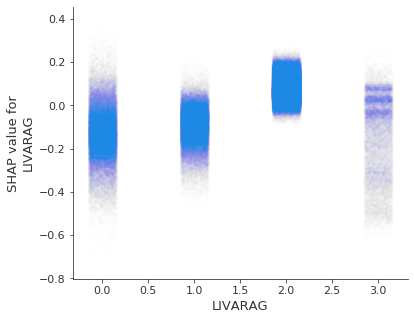

In [157]:
# Show dependence plots for the top n features across all observations
# NOTE: In order to get dependence plot to work, you must revert to matplotlib==3.1.3
# Examples of dependence plots: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

shap.dependence_plot('LIVARAG', shap_values.values, X, x_jitter=0.3, alpha=0.005, interaction_index=None)

In [154]:
shap_importance

,feature_name,feature_importance,feature_importance_out_of_100
3,SERVICES,1.169295,0.221355
0,STFIPS,0.808112,0.152981
6,PSOURCE,0.297946,0.056403
5,NOPRIOR,0.260033,0.049226
31,HLTHINS,0.209499,0.039660
25,FREQ1,0.171629,0.032491
14,DSMCRIT,0.164464,0.031134
33,FREQ_ATND_SELF_HELP,0.139806,0.026466
18,PRIMINC,0.130791,0.024760
32,PRIMPAY,0.129681,0.024550


In [155]:
shap_importance
# shap_importance.to_csv('shap_importance.csv', index=False)

# Grouped feature importance

In [5]:
import pandas as pd
g = pd.read_csv('shap_importance_encoded.csv')  #update label and category, then regroup
g

,feature_name,feature_label,feature_category,feature_importance,feature_importance_out_of_100
0,SERVICES,treatment service,coordination of care,1.169295,0.221355
1,STFIPS,state code,geographic,0.808112,0.152981
2,PSOURCE,referral source,coordination of care,0.297946,0.056403
3,NOPRIOR,prior treatments,medical history,0.260033,0.049226
4,HLTHINS,health insurance,economic,0.209499,0.039660
5,FREQ1,primary frequency,substance use history,0.171629,0.032491
6,DSMCRIT,dsm diagnosis,medical history,0.164464,0.031134
7,FREQ_ATND_SELF_HELP,self help group,medical history,0.139806,0.026466
8,PRIMINC,income source,economic,0.130791,0.024760
9,PRIMPAY,payment source,economic,0.129681,0.024550


In [7]:
g_grouped = g.groupby('feature_category').sum()['feature_importance_out_of_100'].sort_values(ascending=False)
# g_grouped.to_csv('shap_importance_grouped.csv')
g_grouped

feature_category
coordination of care     0.311856
substance use history    0.197930
geographic               0.152981
medical history          0.135583
economic                 0.126462
demographic              0.037923
personal history         0.037266
Name: feature_importance_out_of_100, dtype: float64

In [8]:
g.sort_values(by='feature_importance_out_of_100', ascending=False)[['feature_label', 'feature_importance_out_of_100']].reset_index(drop=True)

,feature_label,feature_importance_out_of_100
0,treatment service,0.221355
1,state code,0.152981
2,referral source,0.056403
3,prior treatments,0.049226
4,health insurance,0.039660
5,primary frequency,0.032491
6,dsm diagnosis,0.031134
7,self help group,0.026466
8,income source,0.024760
9,payment source,0.024550
